<a href="https://colab.research.google.com/github/sksvineeth/Emotion-Detection/blob/main/Compass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install utils
!pip install livelossplot
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


In [22]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 255
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("/content/drive/MyDrive/Compass/Train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("/content/drive/MyDrive/Compass/Train/" + expression + "/" +os.listdir("/content/drive/MyDrive/Compass/Train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

In [20]:
for expression in os.listdir("/content/drive/MyDrive/Compass/Train/"):
    print(str(len(os.listdir("/content/drive/MyDrive/Compass/Train/" + expression))) + " " + expression + " images")

16809 BL images
16809 PA1 images
16806 PA2 images
16810 PA3 images
16014 PA4 images


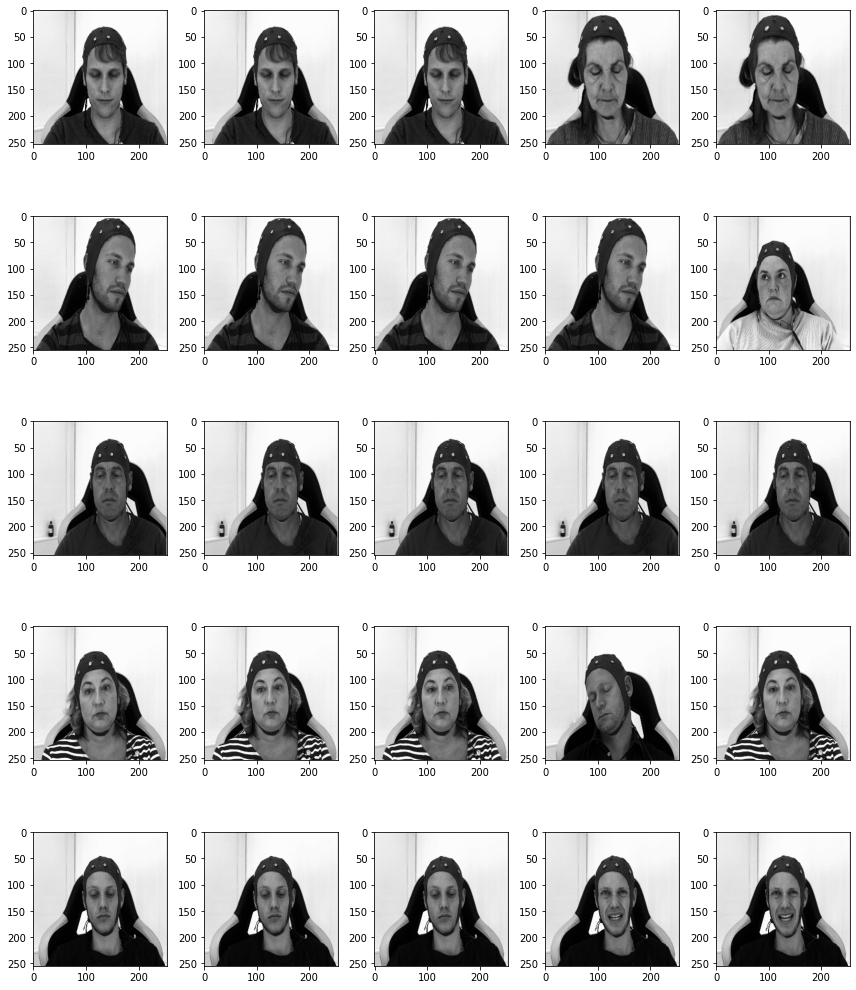

In [23]:
plot_example_images(plt).show()

In [33]:
img_size = 255
batch_size = 128

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/drive/MyDrive/Compass/Train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/drive/MyDrive/Compass/Test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 83248 images belonging to 5 classes.
Found 36015 images belonging to 5 classes.


In [34]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(255, 255 ,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 255, 255, 64)      640       
_________________________________________________________________
batch_normalization_42 (Batc (None, 255, 255, 64)      256       
_________________________________________________________________
activation_42 (Activation)   (None, 255, 255, 64)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 127, 127, 128)     204928    
_________________________________________________________________
batch_normalization_43 (Batc (None, 127, 127, 128)    

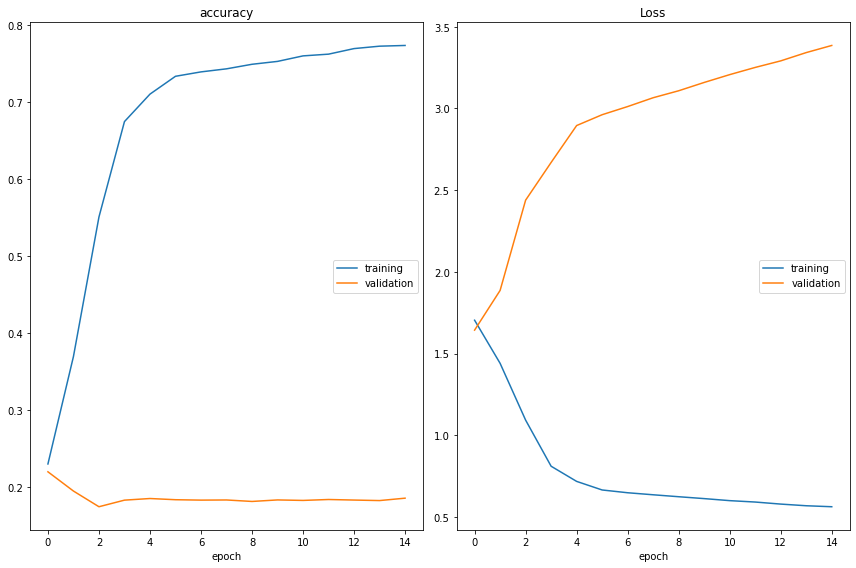

accuracy
	training         	 (min:    0.230, max:    0.774, cur:    0.774)
	validation       	 (min:    0.175, max:    0.220, cur:    0.186)
Loss
	training         	 (min:    0.563, max:    1.704, cur:    0.563)
	validation       	 (min:    1.643, max:    3.385, cur:    3.385)

Epoch 00015: saving model to /content/drive/MyDrive/Compass/model_weights.h5
CPU times: user 1h 24min 59s, sys: 45min 45s, total: 2h 10min 45s
Wall time: 2h 22min 28s


In [35]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Compass/model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [36]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Compass/model.json", "w") as json_file:
    json_file.write(model_json)

In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Apr 19 09:37:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    39W / 250W |  15563MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------